# PyNN example

Renato Naville Watanabe

## Python setup

In [1]:
import shutil
from pyNN.utility.build import compile_nmodl
from neuron import h
from pyNN.standardmodels import StandardIonChannelModel, build_translations
from pyNN.morphology import NeuroMLMorphology, IonChannelDistribution
import pyNN.neuron as sim
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.parameters import IonicSpecies
from pyNN.neuron.morphology import uniform, centre
import numpy as np
from pyNN.utility.plotting import Figure, Panel

/home/renato/pynn_example/.venv/lib/python3.12/site-packages/pyNN/neuron/__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
shutil.copyfile('mn.mod','.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/mn.mod')
compile_nmodl('.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/')
h.nrn_load_dll('.venv/lib/python3.12/site-packages/pyNN/neuron/nmodl/mn.o')

nrnivmodl found at /home/renato/pynn_example/.venv/bin/nrnivmodl
Successfully compiled NEURON extensions.


0.0

## Ionic channels classes  definitions

In [3]:
class KsChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12,
        "e_rev": -80,
        "vt": -57.65
    }
    
    translations = build_translations(
        ('conductance_density', 'gk_slow'),
        ('e_rev', 'eks'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'p': ('motoneuron', 'p'),
    }
    default_initial_values = {
        'p': 1,  
    }
    units = {
        'iks': 'mA/cm2',
        'p': 'dimensionless',
    }
    recordable = ['iks','p']
    model = "motoneuron"
    conductance_density_parameter = 'gk_slow'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

    

In [4]:
class KfChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": -80,
        "vt": -57.65
    }
    
    recordable = ['ikf','n'] 
    translations = build_translations(
        ('conductance_density', 'gk_fast'),
        ('e_rev', 'ekf'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'n': ('motoneuron', 'n'),
    }
    default_initial_values = {
        'n': 1,  # initial value for gating variable m
    }
    units = {
        'ikf': 'mA/cm2',
        'n': 'dimensionless',
    }
    model = "motoneuron"
    conductance_density_parameter = 'gk_fast'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [5]:
class NaChannel(StandardIonChannelModel):
    default_parameters = {
        "conductance_density": 0.12, #uniform('all', 0.12),
        "e_rev": 50,
        "vt":-57.65,
    }
    
    default_initial_values = {
        'm': 1.0,  # initial value for gating variable m
        'h': 0.0,  # initial value for gating variable h
    }
    recordable = ['ina', 'm', 'h']
    units = {
        'ina': 'mA/cm2',
        'm': 'dimensionless',
        'h': 'dimensionless',
    }
    translations = build_translations(
        ('conductance_density', 'gna'),
        ('e_rev', 'ena'),
        ('vt', 'vt'),
    )
    variable_translations = {
        'h': ('motoneuron', 'h'),
        'm': ('motoneuron', 'm'),
        'ina': ('motoneuron', 'ina'),
    }
    model = "motoneuron"
    conductance_density_parameter = 'gna'
    def get_schema(self):
        return {
            "conductance_density": IonChannelDistribution,
            "e_rev": float,
            "vt": float
        }

In [6]:
class PassiveLeak(StandardIonChannelModel):
    translations = build_translations(
        ('conductance_density', 'gl'),
        ('e_rev', 'el'),
    )
    variable_translations = {}
    model = "motoneuron"
    conductance_density_parameter = 'gl'

## Motoneuron class definition

In [7]:
class mn_class(sim.MultiCompartmentNeuron):
    def __init__(self, **parameters):

        self.label = "mn1"
        self.ion_channels = {'pas_soma': PassiveLeak, 'pas_dend': sim.PassiveLeak,
                           'na': NaChannel, 'kf': KfChannel, 'ks': KsChannel}
        self.units = {'v':'mV',
                      'gsyn_exc': 'uS',
                      'gsyn_inh': 'uS',
                      'na.m': 'dimensionless', 'na.h': 'dimensionless', 'kf.n': 'dimensionless', 
                      'ks.p': 'dimensionless', 'na.ina': 'mA/cm2', 'kf.ikf': 'mA/cm2', 
                      'ks.iks': 'mA/cm2'}
        self.post_synaptic_entities = {'syn': sim.CondExpPostSynapticResponse}
        
        super(mn_class, self).__init__(**parameters)

## Defining the fucntions to build the motoneuron population

In [8]:
def create_somas(n):
    somas = []
    for i in range(n):
        diameter = 77.5 + i * ((82.5-77.5)/n)
        y = i * (18/n)
        soma= Segment(proximal=P(x=diameter, y=y, z=0, diameter=diameter),
                       distal=P(x=0, y=y, z=0, diameter=diameter),
                       name="soma", id=0)
        somas.append(soma)
    return somas

def create_dends(n,somas):
     dends=[]
     for i in range(n):
        y = i * (18/n)
        diameter = 41.5 + i * ((62.5-41.5)/n)
        x_distal= -5500 + i * ((-6789+5500)/n)
        dend = Segment(proximal=P(x=0, y=y, z=0, diameter=diameter),
               distal=P(x=x_distal, y=y, z=0, diameter=diameter),
               name="dendrite",
               parent=somas[i], id=1)
        dends.append(dend)
     return dends

def soma_dend(somas, dends):
    combined= []
    for i in range(len(dends)):
        combineds=NeuroMLMorphology(Morphology(segments=(somas[i], 
                                                dends[i])))
        combined.append(combineds)
    return combined

In [9]:
n = 100
somas= create_somas(n)
dendrites = create_dends(n,somas)
neurons = soma_dend(somas, dendrites)

## Creating the motoneuron population

In [10]:
mn = mn_class(
     morphology= neurons,
     cm=1,    # mF / cm**2
     Ra=0.070, # ohm.mm
     ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
     pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
     pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
     na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53, n))},
     kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53, n))},
     ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53, n))},

     syn={"locations": centre('dendrite'),
          "e_syn": 0,
          "tau_syn": 0.6},  
)

In [11]:
cells = sim.Population(n, mn, initial_values={'v': list(-70*np.ones(n))})

## Injected current definition

In [12]:
step_current_dend = sim.DCSource(amplitude=300, start=0, stop=100)
step_current_dend.inject_into(cells, location='dendrite')

## Definition of the signals to be recorded

In [13]:
cells.record('spikes')
cells[[0,50]].record('v', locations=('dendrite','soma'))
cells[[0,50]].record(('na.m', 'na.h'), locations='soma')
cells[[0,50]].record(('kf.n'), locations='soma')
cells[[0,50]].record(('ks.p'), locations='soma')

## Running the simulation

In [14]:
sim.run(100)

100.00000000001417

## Plotting the results

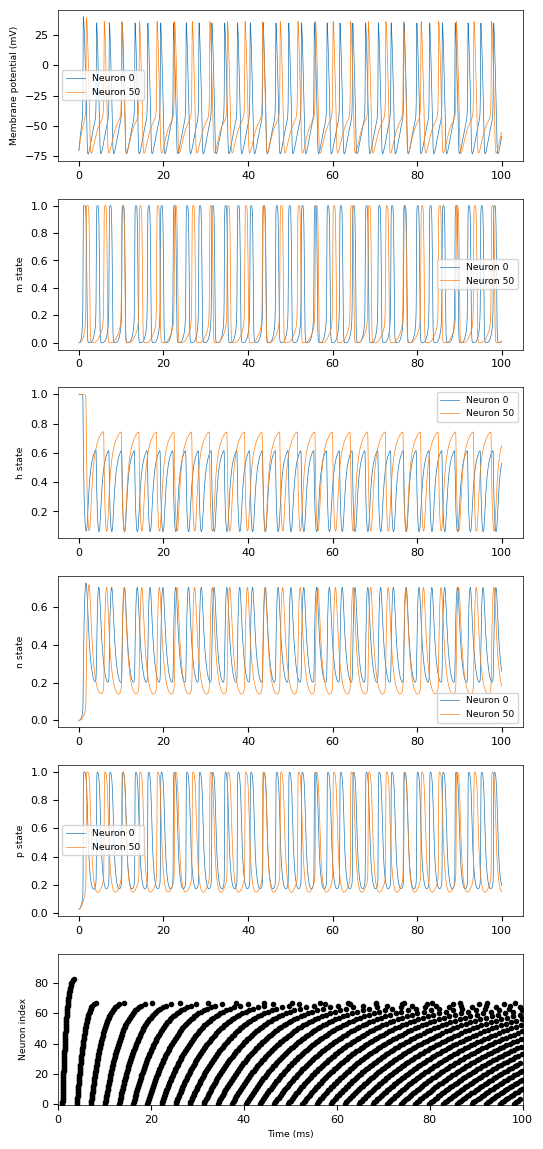

In [16]:
figure_filename = 'test.png'

data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]

Figure(
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)